In [1]:
############## SURVIVAL ANALYSIS BY CLINICAL VARIABLES ###########################

# Import necessary libraries
import pandas as pd

# Load file containing other variables
df_variables = pd.read_excel('Samples_alltypedata_annotated.xlsx')

# Remove the first two rows from df_variables
df_variables = df_variables.iloc[2:].reset_index(drop=True)
print(df_variables.head())

########Firstly we change misclassified samples to redo the analysis  #######################
# Change the values to 'MMRp' for samples 'LP20', 'LP26', and 'MDA15'
# We use .loc[] to access specific rows where 'ID_CNIO' matches one of the specified samples
df_variables.loc[df_variables['ID_CNIO'].isin(['LP20', 'LP26', 'MDA15']), 'MMR_final_status'] = 'MMRp'

# Change the values to 'MMRd' for sample 'MDA26' 
df_variables.loc[df_variables['ID_CNIO'].isin(['MDA26']), 'MMR_final_status'] = 'MMRd'

# Remove samples with artefacts in variant calling an mixed case (RVB3)
df_variables = df_variables[~df_variables['ID_CNIO'].isin(['OVE44', 'OVE16','RVB3'])]

  ID_CNIO ID_ORIGINAL ID_ORIGINAL_NHC_BBANK HISTOLOGY HISTOLOGY_DETAIL AGE  \
0     LP1    02B28662                   NaN         0         No mixed  50   
1     LP2    08B18876                   NaN         0         No mixed  42   
2     LP3     08B260A                   NaN         0         No mixed  68   
3     LP4    11B18858                   NaN         0         No mixed  50   
4     LP5     99B6752                   NaN         0         No mixed  82   

  GRADE FIGO FIGOL FIGOa  ... Non-MMRd_mutation TILs_score_info  \
0     2    3     0     1  ...                NO             YES   
1     2    3     0     1  ...                NO             YES   
2     2    5     0     2  ...                NO             YES   
3     1    6     0     2  ...                NO             YES   
4     1    1     0     1  ...                NO             YES   

  TILs_CNIO_info TILs_ep_CNIO TILs_ep_LP TILs_ep_OTTA TILs_tu_CNIO TILs_tu_LP  \
0   YES_complete            1          9       

In [3]:
# Install library for survival analysis
!pip install lifelines

In [4]:
# Convert OS from days to months using a more accurate average of 30.44 days per month
df_variables['OS_MONTHS'] = df_variables['OS_CNIO'] / 30.44  # More accurate conversion
# Display the updated DataFrame to verify the conversion
print(df_variables[['OS_CNIO', 'OS_MONTHS']].head())

  OS_CNIO   OS_MONTHS
0    5568  182.917214
1    5163  169.612352
2    3047  100.098555
3    3497  114.881735
4    2534   83.245729


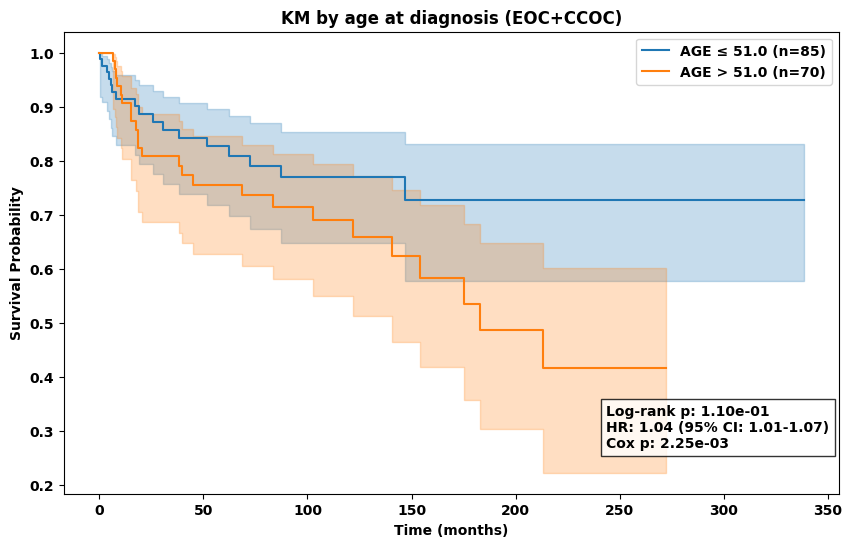

In [5]:
### SURVIVAL ANALYSIS ALL COHORT: AGE VARIABLE ###############

# Import required libraries
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
# import pandas as pd
import matplotlib.pyplot as plt

# Convert OS_MONTHS, VITAL STATUS, and AGE to numeric after making an explicit copy of the DataFrame
df_clean = df_variables.dropna(subset=['VITAL STATUS', 'OS_MONTHS', 'AGE']).copy()
df_clean['OS_MONTHS'] = pd.to_numeric(df_clean['OS_MONTHS'], errors='coerce')
df_clean['VITAL STATUS'] = pd.to_numeric(df_clean['VITAL STATUS'], errors='coerce')
df_clean['AGE'] = pd.to_numeric(df_clean['AGE'], errors='coerce')

# Drop any remaining rows with NaN values after conversion
df_clean = df_clean.dropna(subset=['VITAL STATUS', 'OS_MONTHS', 'AGE']).copy()

# Perform Cox proportional hazards model with AGE
cox_data = df_clean[['OS_MONTHS', 'VITAL STATUS', 'AGE']].copy()
cox_data.rename(columns={'OS_MONTHS': 'duration', 'VITAL STATUS': 'event'}, inplace=True)

cox_model = CoxPHFitter()
cox_model.fit(cox_data, duration_col='duration', event_col='event')

# Extract results from Cox model
cox_summary = cox_model.summary.loc['AGE']
hr = cox_summary['exp(coef)']
hr_lower = cox_summary['exp(coef) lower 95%']
hr_upper = cox_summary['exp(coef) upper 95%']
cox_p_value = cox_summary['p']

# Split AGE into two groups for Kaplan-Meier: above and below median age
median_age = df_clean['AGE'].median()
df_age_low = df_clean[df_clean['AGE'] <= median_age]
df_age_high = df_clean[df_clean['AGE'] > median_age]

# Initialize Kaplan-Meier fitters
kmf_low = KaplanMeierFitter()
kmf_high = KaplanMeierFitter()

# Plot survival curves
plt.figure(figsize=(10, 6))

kmf_low.fit(durations=df_age_low['OS_MONTHS'], 
            event_observed=df_age_low['VITAL STATUS'], 
            label=f"AGE ≤ {median_age} (n={len(df_age_low)})")
ax = kmf_low.plot_survival_function(ci_show=True)

kmf_high.fit(durations=df_age_high['OS_MONTHS'], 
             event_observed=df_age_high['VITAL STATUS'], 
             label=f"AGE > {median_age} (n={len(df_age_high)})")
kmf_high.plot_survival_function(ax=ax, ci_show=True)

# Perform log-rank test
logrank_results = logrank_test(df_age_low['OS_MONTHS'], df_age_high['OS_MONTHS'],
                               event_observed_A=df_age_low['VITAL STATUS'],
                               event_observed_B=df_age_high['VITAL STATUS'])

logrank_p_value = logrank_results.p_value

# Annotate the plot with log-rank p-value, HR, and CI from Cox model
plt.text(0.7, 0.1, f"Log-rank p: {logrank_p_value:.2e}\n"
                   f"HR: {hr:.2f} (95% CI: {hr_lower:.2f}-{hr_upper:.2f})\n"
                   f"Cox p: {cox_p_value:.2e}",fontweight='bold',
         transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# Finalize plot
plt.title("KM by age at diagnosis (EOC+CCOC)",fontweight='bold')
plt.xlabel("Time (months)",fontweight='bold')
plt.ylabel("Survival Probability",fontweight='bold')

# Update axes tick labels to bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

# Update legend to bold
plt.legend(fontsize=10, title_fontsize=10, prop={'weight': 'bold'})
# Show
plt.show()


Analyzing CCOC...
HR: 1.02 (95% CI: 0.98-1.06), Cox p-value: 4.45e-01


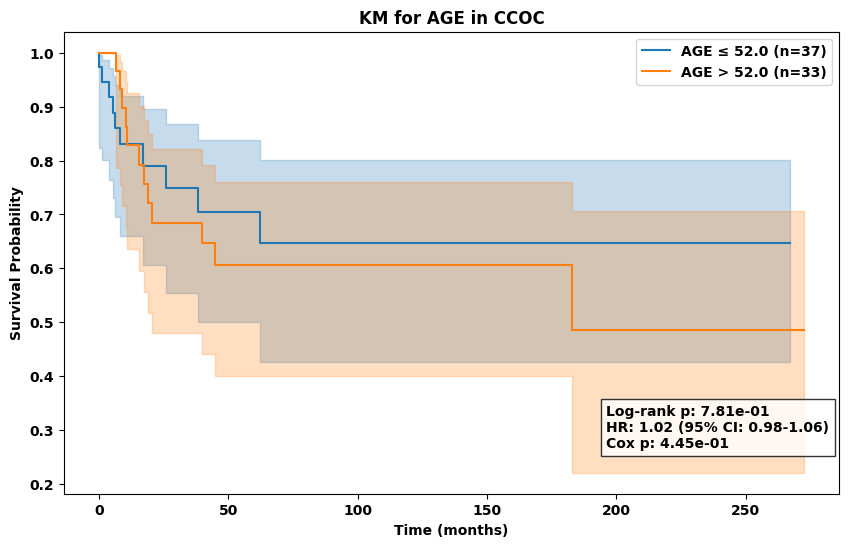


Analyzing EOC...
HR: 1.06 (95% CI: 1.03-1.10), Cox p-value: 6.42e-04


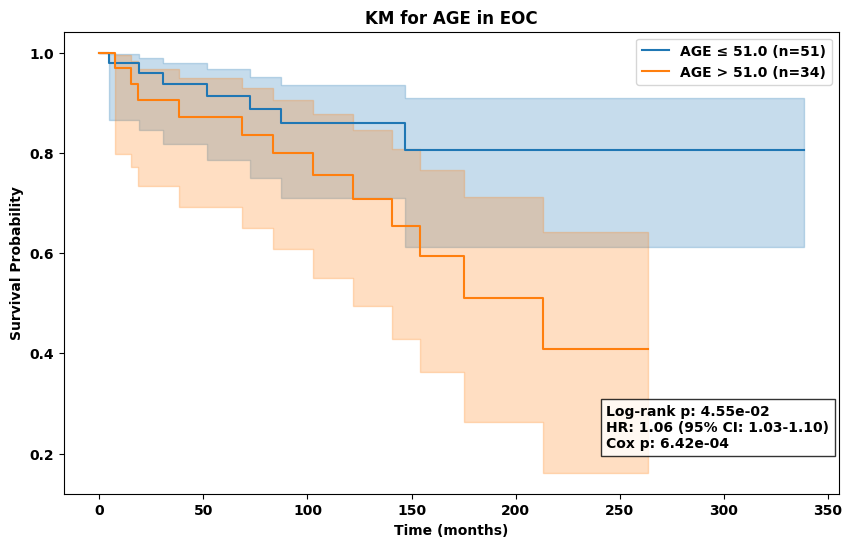

In [8]:
#### SURVIVAL ANALYSIS BY HISTOTYPE: AGE VARIABLE ###############

# Uncomment to import if not previously done
#from lifelines import KaplanMeierFitter, CoxPHFitter
#from lifelines.statistics import logrank_test
# import pandas as pd
#import matplotlib.pyplot as plt

# Step 1: Calculate the median ages by HISTOLOGY group before filtering
df_medians = df_variables.dropna(subset=['AGE', 'HISTOLOGY']).copy()  # Only AGE and HISTOLOGY are needed here
median_age_by_histology = df_medians.groupby('HISTOLOGY')['AGE'].median()

# Step 2: Filter valid data in the required columns (not considering medians here)
df_clean = df_variables.dropna(subset=['VITAL STATUS', 'OS_MONTHS', 'AGE', 'HISTOLOGY']).copy()

# Convert key columns to numeric types
df_clean['OS_MONTHS'] = pd.to_numeric(df_clean['OS_MONTHS'], errors='coerce')
df_clean['VITAL STATUS'] = pd.to_numeric(df_clean['VITAL STATUS'], errors='coerce')
df_clean['AGE'] = pd.to_numeric(df_clean['AGE'], errors='coerce')

# Map HISTOLOGY values to readable labels (if needed)
df_clean['HISTOLOGY_LABEL'] = df_clean['HISTOLOGY'].map({0: 'EOC', 1: 'CCOC'})

# Step 3: Perform analysis for each HISTOLOGY group
for histology_type, histology_data in df_clean.groupby('HISTOLOGY_LABEL'):
    print(f"\nAnalyzing {histology_type}...")
    
    # Retrieve the pre-calculated median age for this HISTOLOGY group
    histology_code = histology_data['HISTOLOGY'].iloc[0]  # Identify the HISTOLOGY code
    median_age = median_age_by_histology[histology_code]
    
    # Create subsets based on the pre-calculated median age
    df_age_low = histology_data[histology_data['AGE'] <= median_age]
    df_age_high = histology_data[histology_data['AGE'] > median_age]
    
    # Cox Proportional Hazards Model for AGE
    cox_data = histology_data[['OS_MONTHS', 'VITAL STATUS', 'AGE']].copy()
    cox_data.rename(columns={'OS_MONTHS': 'duration', 'VITAL STATUS': 'event'}, inplace=True)
    
    cox_model = CoxPHFitter()
    cox_model.fit(cox_data, duration_col='duration', event_col='event')
    
    # Extract results from the Cox model
    cox_summary = cox_model.summary.loc['AGE']
    hr = cox_summary['exp(coef)']  # Hazard Ratio
    hr_lower = cox_summary['exp(coef) lower 95%']  # Lower bound of 95% CI
    hr_upper = cox_summary['exp(coef) upper 95%']  # Upper bound of 95% CI
    cox_p_value = cox_summary['p']  # p-value of the Cox model
    print(f"HR: {hr:.2f} (95% CI: {hr_lower:.2f}-{hr_upper:.2f}), Cox p-value: {cox_p_value:.2e}")
    
    # Kaplan-Meier Analysis
    # Initialize Kaplan-Meier fitters
    kmf_low = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()
    

    # Plot survival curves 
    plt.figure(figsize=(10, 6))
    
    kmf_low.fit(durations=df_age_low['OS_MONTHS'], 
                event_observed=df_age_low['VITAL STATUS'], 
                label=f"AGE ≤ {median_age} (n={len(df_age_low)})")
    ax = kmf_low.plot_survival_function(ci_show=True)
    
    kmf_high.fit(durations=df_age_high['OS_MONTHS'], 
                 event_observed=df_age_high['VITAL STATUS'], 
                 label=f"AGE > {median_age} (n={len(df_age_high)})")
    kmf_high.plot_survival_function(ax=ax, ci_show=True)
    
    # Log-rank test
    logrank_results = logrank_test(df_age_low['OS_MONTHS'], df_age_high['OS_MONTHS'],
                                   event_observed_A=df_age_low['VITAL STATUS'],
                                   event_observed_B=df_age_high['VITAL STATUS'])
    
    logrank_p_value = logrank_results.p_value  # Extract p-value from log-rank test
    
    # Annotate the plot
    plt.text(0.7, 0.1, f"Log-rank p: {logrank_p_value:.2e}\n"
                       f"HR: {hr:.2f} (95% CI: {hr_lower:.2f}-{hr_upper:.2f})\n"
                       f"Cox p: {cox_p_value:.2e}", fontweight='bold',
             transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    # Finalize the plot
    plt.title(f"KM for AGE in {histology_type}", fontweight='bold')  # Bold title
    plt.xlabel("Time (months)", fontweight='bold')  # Bold X-axis label
    plt.ylabel("Survival Probability", fontweight='bold')  # Bold Y-axis label
    
    # Set axis tick labels to bold
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')

    # Update legend with bold text
    plt.legend(fontsize=10, title_fontsize=10, prop={'weight': 'bold'})
    
    # Show
    plt.show()


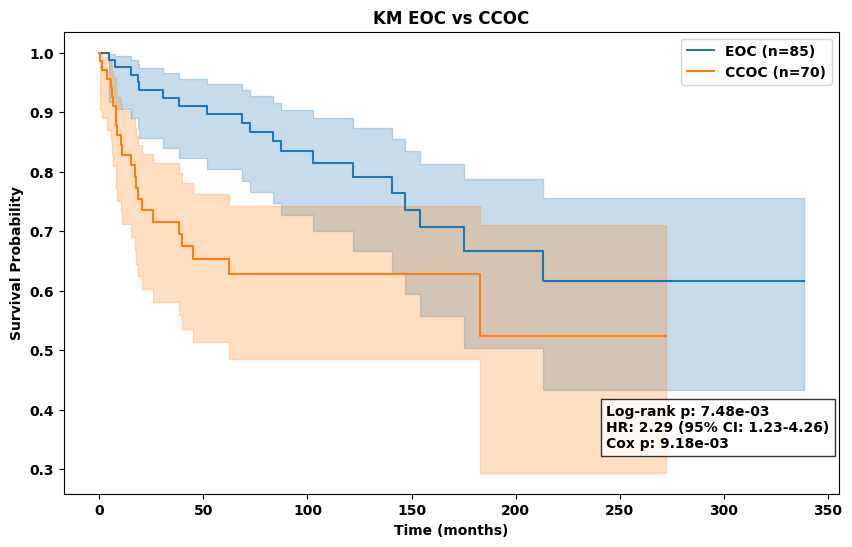

In [9]:
#### SURVIVAL ANALYSIS BY HISTOTYPE ###############

# Uncomment to import if not previously done
#from lifelines import KaplanMeierFitter, CoxPHFitter
#from lifelines.statistics import logrank_test
# import pandas as pd
#import matplotlib.pyplot as plt

# Map HISTOLOGY values: 0 to "EOC" and 1 to "CC"
df_variables['HISTOLOGY_LABEL'] = df_variables['HISTOLOGY'].map({0: 'EOC', 1: 'CCOC'})

# Convert OS_MONTHS and VITAL STATUS to numeric after making an explicit copy of the DataFrame
df_clean = df_variables.dropna(subset=['VITAL STATUS', 'OS_MONTHS']).copy()
df_clean['OS_MONTHS'] = pd.to_numeric(df_clean['OS_MONTHS'], errors='coerce')
df_clean['VITAL STATUS'] = pd.to_numeric(df_clean['VITAL STATUS'], errors='coerce')

# Drop any remaining rows with NaN values after conversion
df_clean = df_clean.dropna(subset=['VITAL STATUS', 'OS_MONTHS']).copy()

# Perform Cox proportional hazards model
cox_data = df_clean[['OS_MONTHS', 'VITAL STATUS', 'HISTOLOGY']].copy()
cox_data.rename(columns={'OS_MONTHS': 'duration', 'VITAL STATUS': 'event'}, inplace=True)

cox_model = CoxPHFitter()
cox_model.fit(cox_data, duration_col='duration', event_col='event')

# Extract results from Cox model
cox_summary = cox_model.summary.loc['HISTOLOGY']
hr = cox_summary['exp(coef)']
hr_lower = cox_summary['exp(coef) lower 95%']
hr_upper = cox_summary['exp(coef) upper 95%']
cox_p_value = cox_summary['p']

# Separate data into two groups for Kaplan-Meier
df_histology_e = df_clean[df_clean['HISTOLOGY_LABEL'] == 'EOC']
df_histology_cc = df_clean[df_clean['HISTOLOGY_LABEL'] == 'CCOC']

# Initialize Kaplan-Meier fitters
kmf_e = KaplanMeierFitter()
kmf_cc = KaplanMeierFitter()

# Plot survival curves
plt.figure(figsize=(10, 6))

kmf_e.fit(durations=df_histology_e['OS_MONTHS'], 
          event_observed=df_histology_e['VITAL STATUS'], 
          label=f"EOC (n={len(df_histology_e)})")
ax = kmf_e.plot_survival_function(ci_show=True)

kmf_cc.fit(durations=df_histology_cc['OS_MONTHS'], 
           event_observed=df_histology_cc['VITAL STATUS'], 
           label=f"CCOC (n={len(df_histology_cc)})")
kmf_cc.plot_survival_function(ax=ax, ci_show=True)

# Perform log-rank test
logrank_results = logrank_test(df_histology_e['OS_MONTHS'], df_histology_cc['OS_MONTHS'],
                               event_observed_A=df_histology_e['VITAL STATUS'],
                               event_observed_B=df_histology_cc['VITAL STATUS'])

logrank_p_value = logrank_results.p_value

# Annotate the plot with log-rank p-value, HR, and CI from Cox model
plt.text(0.7, 0.1, f"Log-rank p: {logrank_p_value:.2e}\n"
                   f"HR: {hr:.2f} (95% CI: {hr_lower:.2f}-{hr_upper:.2f})\n"
                   f"Cox p: {cox_p_value:.2e}",fontweight='bold',
         transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# Finalize plot
plt.title("KM EOC vs CCOC",fontweight='bold')
plt.xlabel("Time (months)",fontweight='bold')
plt.ylabel("Survival Probability",fontweight='bold')

# Set axis tick labels to bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

# Update legend with bold text
plt.legend(fontsize=10, title_fontsize=10, prop={'weight': 'bold'})

# Show
plt.show()


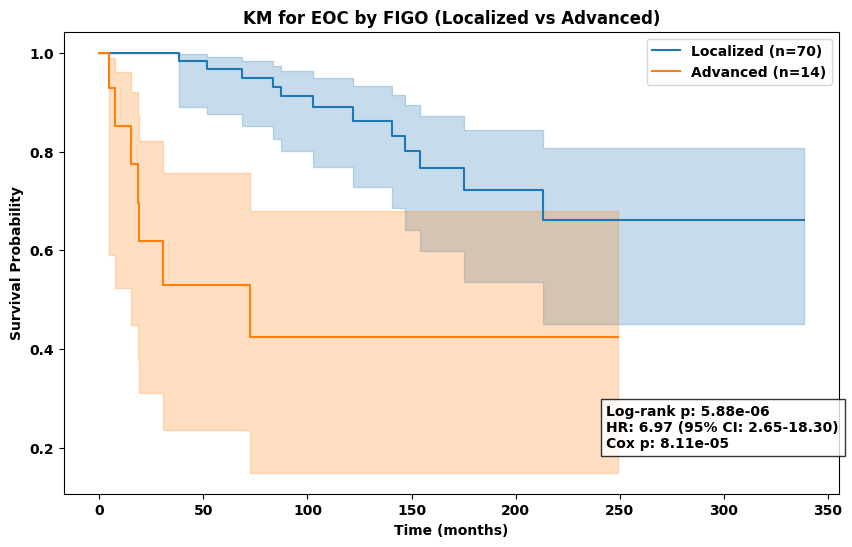

In [10]:
#### SURVIVAL ANALYSIS FOR EOC BY FIGO ############

# Uncomment to import if not previously done
#from lifelines import KaplanMeierFitter, CoxPHFitter
#from lifelines.statistics import logrank_test
# import pandas as pd
#import matplotlib.pyplot as plt

# Filter for EOC samples and drop NaN values
df_eoc = df_variables[(df_variables['HISTOLOGY_LABEL'] == 'EOC')].dropna(subset=['VITAL STATUS', 'OS_MONTHS', 'FIGOL']).copy()

# Convert columns to numeric
df_eoc['OS_MONTHS'] = pd.to_numeric(df_eoc['OS_MONTHS'], errors='coerce')
df_eoc['VITAL STATUS'] = pd.to_numeric(df_eoc['VITAL STATUS'], errors='coerce')
df_eoc['FIGOL'] = pd.to_numeric(df_eoc['FIGOL'], errors='coerce')

# Separate into FIGOL groups
df_localized = df_eoc[df_eoc['FIGOL'] == 0]
df_advanced = df_eoc[df_eoc['FIGOL'] == 1]

# Perform Cox proportional hazards model
cox_data = df_eoc[['OS_MONTHS', 'VITAL STATUS', 'FIGOL']].copy()
cox_data.rename(columns={'OS_MONTHS': 'duration', 'VITAL STATUS': 'event'}, inplace=True)

cox_model = CoxPHFitter()
cox_model.fit(cox_data, duration_col='duration', event_col='event')

# Extract results from Cox model
cox_summary = cox_model.summary.loc['FIGOL']
hr = cox_summary['exp(coef)']
hr_lower = cox_summary['exp(coef) lower 95%']
hr_upper = cox_summary['exp(coef) upper 95%']
cox_p_value = cox_summary['p']

# Initialize Kaplan-Meier fitters
kmf_localized = KaplanMeierFitter()
kmf_advanced = KaplanMeierFitter()

# Plot survival curves
plt.figure(figsize=(10, 6))

kmf_localized.fit(durations=df_localized['OS_MONTHS'], 
                  event_observed=df_localized['VITAL STATUS'], 
                  label=f"Localized (n={len(df_localized)})")
ax = kmf_localized.plot_survival_function(ci_show=True)

kmf_advanced.fit(durations=df_advanced['OS_MONTHS'], 
                 event_observed=df_advanced['VITAL STATUS'], 
                 label=f"Advanced (n={len(df_advanced)})")
kmf_advanced.plot_survival_function(ax=ax, ci_show=True)

# Perform log-rank test
logrank_results = logrank_test(df_localized['OS_MONTHS'], df_advanced['OS_MONTHS'],
                               event_observed_A=df_localized['VITAL STATUS'],
                               event_observed_B=df_advanced['VITAL STATUS'])

logrank_p_value = logrank_results.p_value

# Annotate the plot with log-rank p-value, HR, and CI from Cox model
plt.text(0.7, 0.1, f"Log-rank p: {logrank_p_value:.2e}\n"
                   f"HR: {hr:.2f} (95% CI: {hr_lower:.2f}-{hr_upper:.2f})\n"
                   f"Cox p: {cox_p_value:.2e}",fontweight='bold',
         transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# Finalize plot
plt.title("KM for EOC by FIGO (Localized vs Advanced)", fontweight='bold')
plt.xlabel("Time (months)",fontweight='bold')
plt.ylabel("Survival Probability",fontweight='bold')
# Set axis tick labels to bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

# Update legend with bold text
plt.legend(fontsize=10, title_fontsize=10, prop={'weight': 'bold'})

# Show
plt.show()

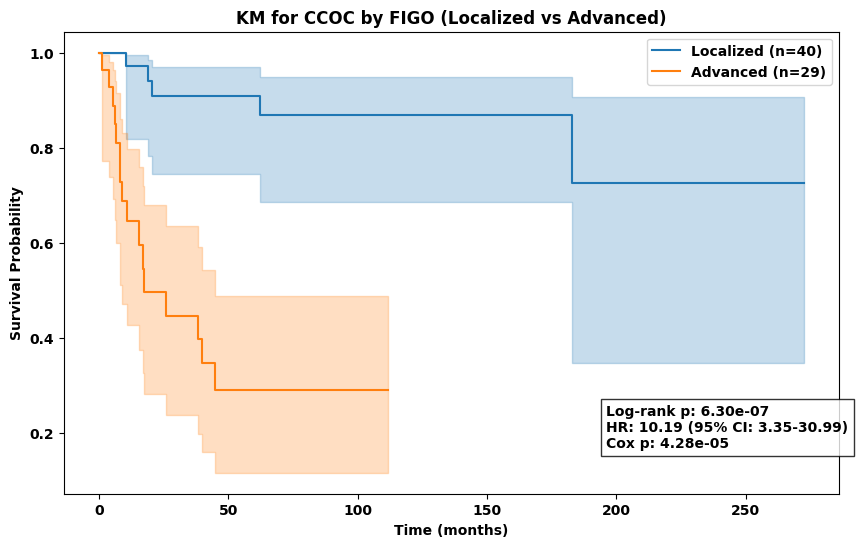

In [11]:
## SURVIVAL ANALYSIS FOR CCOC BY FIGO  #######################

# Uncomment to import if not previously done
#from lifelines import KaplanMeierFitter, CoxPHFitter
#from lifelines.statistics import logrank_test
# import pandas as pd
#import matplotlib.pyplot as plt

# Filter for CCOC samples and drop NaN values
df_cc = df_variables[(df_variables['HISTOLOGY_LABEL'] == 'CCOC')].dropna(subset=['VITAL STATUS', 'OS_MONTHS', 'FIGOL']).copy()

# Convert columns to numeric
df_cc['OS_MONTHS'] = pd.to_numeric(df_cc['OS_MONTHS'], errors='coerce')
df_cc['VITAL STATUS'] = pd.to_numeric(df_cc['VITAL STATUS'], errors='coerce')
df_cc['FIGOL'] = pd.to_numeric(df_cc['FIGOL'], errors='coerce')

# Separate into FIGOL groups
df_localized = df_cc[df_cc['FIGOL'] == 0]
df_advanced = df_cc[df_cc['FIGOL'] == 1]

# Perform Cox proportional hazards model
cox_data = df_cc[['OS_MONTHS', 'VITAL STATUS', 'FIGOL']].copy()
cox_data.rename(columns={'OS_MONTHS': 'duration', 'VITAL STATUS': 'event'}, inplace=True)

cox_model = CoxPHFitter()
cox_model.fit(cox_data, duration_col='duration', event_col='event')

# Extract results from Cox model
cox_summary = cox_model.summary.loc['FIGOL']
hr = cox_summary['exp(coef)']
hr_lower = cox_summary['exp(coef) lower 95%']
hr_upper = cox_summary['exp(coef) upper 95%']
cox_p_value = cox_summary['p']

# Initialize Kaplan-Meier fitters
kmf_localized = KaplanMeierFitter()
kmf_advanced = KaplanMeierFitter()

# Plot survival curves
plt.figure(figsize=(10, 6))

kmf_localized.fit(durations=df_localized['OS_MONTHS'], 
                  event_observed=df_localized['VITAL STATUS'], 
                  label=f"Localized (n={len(df_localized)})")
ax = kmf_localized.plot_survival_function(ci_show=True)

kmf_advanced.fit(durations=df_advanced['OS_MONTHS'], 
                 event_observed=df_advanced['VITAL STATUS'], 
                 label=f"Advanced (n={len(df_advanced)})")
kmf_advanced.plot_survival_function(ax=ax, ci_show=True)

# Perform log-rank test
logrank_results = logrank_test(df_localized['OS_MONTHS'], df_advanced['OS_MONTHS'],
                               event_observed_A=df_localized['VITAL STATUS'],
                               event_observed_B=df_advanced['VITAL STATUS'])

logrank_p_value = logrank_results.p_value

# Annotate the plot with log-rank p-value, HR, and CI from Cox model
plt.text(0.7, 0.1, f"Log-rank p: {logrank_p_value:.2e}\n"
                   f"HR: {hr:.2f} (95% CI: {hr_lower:.2f}-{hr_upper:.2f})\n"
                   f"Cox p: {cox_p_value:.2e}",fontweight='bold',
         transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# Finalize plot
plt.title("KM for CCOC by FIGO (Localized vs Advanced)",fontweight='bold')
plt.xlabel("Time (months)",fontweight='bold')
plt.ylabel("Survival Probability",fontweight='bold')
# Set axis tick labels to bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

# Update legend with bold text
plt.legend(fontsize=10, title_fontsize=10, prop={'weight': 'bold'})

# Show
plt.show()

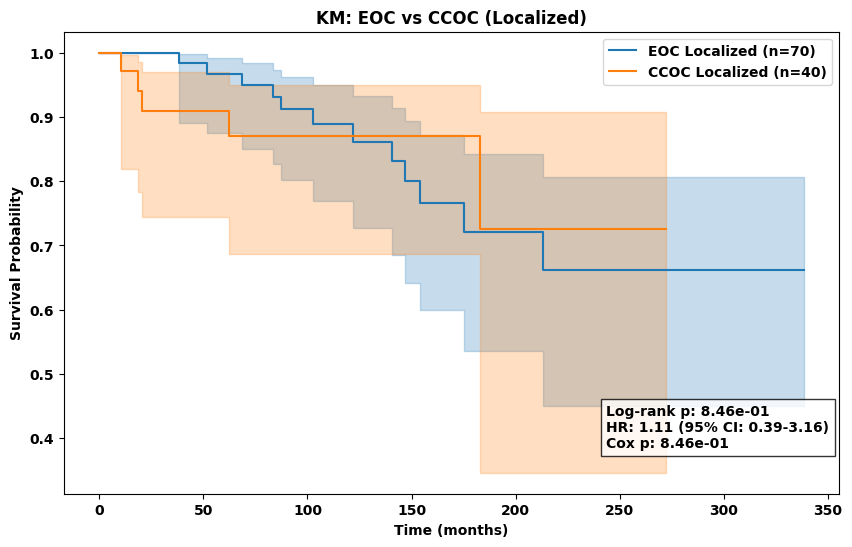

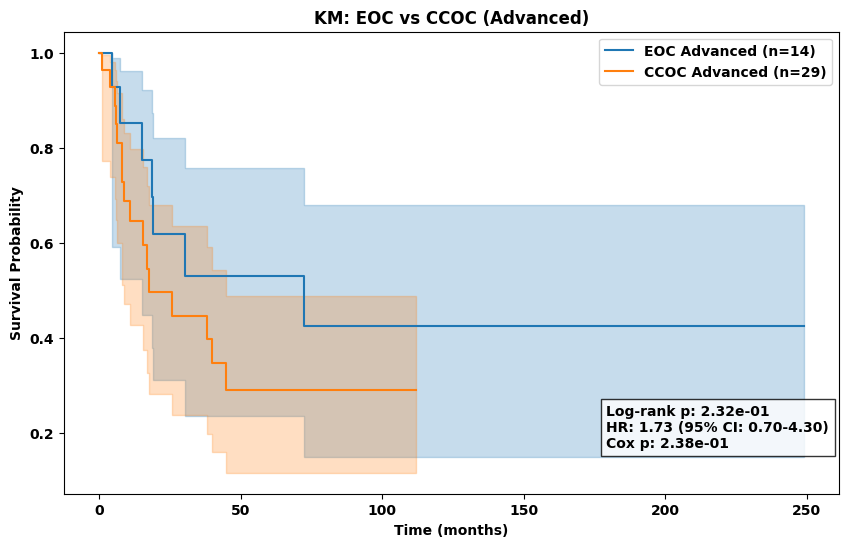

In [12]:
## SURVIVAL ANALYSIS IN EVERY FIGO STAGE CATEGORY. COMPARE EOC VS CCOC #######

# Uncomment to import if not previously done
#from lifelines import KaplanMeierFitter, CoxPHFitter
#from lifelines.statistics import logrank_test
# import pandas as pd
#import matplotlib.pyplot as plt

# Prepare data for analysis
df_clean = df_variables.dropna(subset=['VITAL STATUS', 'OS_MONTHS', 'HISTOLOGY_LABEL', 'FIGOL']).copy()

# Convert relevant columns to numeric
df_clean['OS_MONTHS'] = pd.to_numeric(df_clean['OS_MONTHS'], errors='coerce')
df_clean['VITAL STATUS'] = pd.to_numeric(df_clean['VITAL STATUS'], errors='coerce')
df_clean['FIGOL'] = pd.to_numeric(df_clean['FIGOL'], errors='coerce')

# Separate groups by HISTOLOGY and FIGOL
df_eoc_localized = df_clean[(df_clean['HISTOLOGY_LABEL'] == 'EOC') & (df_clean['FIGOL'] == 0)]
df_ccoc_localized = df_clean[(df_clean['HISTOLOGY_LABEL'] == 'CCOC') & (df_clean['FIGOL'] == 0)]
df_eoc_advanced = df_clean[(df_clean['HISTOLOGY_LABEL'] == 'EOC') & (df_clean['FIGOL'] == 1)]
df_ccoc_advanced = df_clean[(df_clean['HISTOLOGY_LABEL'] == 'CCOC') & (df_clean['FIGOL'] == 1)]

# Define a function to plot Kaplan-Meier curves and perform log-rank test and Cox model
def plot_km_and_cox(df_group1, df_group2, group1_label, group2_label, title, filename, figol_value):
    # Combine the two groups for Cox analysis
    combined_data = pd.concat([df_group1, df_group2], axis=0)
    combined_data['Group'] = combined_data['HISTOLOGY_LABEL'].map({'EOC': 0, 'CCOC': 1})
    
    # Prepare Cox model data
    cox_data = combined_data[['OS_MONTHS', 'VITAL STATUS', 'Group']].copy()
    cox_data.rename(columns={'OS_MONTHS': 'duration', 'VITAL STATUS': 'event'}, inplace=True)
    
    # Fit Cox model
    cox_model = CoxPHFitter()
    cox_model.fit(cox_data, duration_col='duration', event_col='event')
    
    # Extract Cox model results
    cox_summary = cox_model.summary.loc['Group']
    hr = cox_summary['exp(coef)']
    hr_lower = cox_summary['exp(coef) lower 95%']
    hr_upper = cox_summary['exp(coef) upper 95%']
    cox_p_value = cox_summary['p']
    
    # Initialize Kaplan-Meier fitters
    kmf1 = KaplanMeierFitter()
    kmf2 = KaplanMeierFitter()
    
    # Fit the data
    plt.figure(figsize=(10, 6))
    kmf1.fit(durations=df_group1['OS_MONTHS'], 
             event_observed=df_group1['VITAL STATUS'], 
             label=f"{group1_label} (n={len(df_group1)})")
    ax = kmf1.plot_survival_function(ci_show=True)

    kmf2.fit(durations=df_group2['OS_MONTHS'], 
             event_observed=df_group2['VITAL STATUS'], 
             label=f"{group2_label} (n={len(df_group2)})")
    kmf2.plot_survival_function(ax=ax, ci_show=True)

    # Perform log-rank test
    logrank_results = logrank_test(df_group1['OS_MONTHS'], df_group2['OS_MONTHS'],
                                   event_observed_A=df_group1['VITAL STATUS'],
                                   event_observed_B=df_group2['VITAL STATUS'])
    logrank_p_value = logrank_results.p_value

    # Annotate the plot with log-rank p-value, HR, and CI from Cox model
    plt.text(0.7, 0.1, f"Log-rank p: {logrank_p_value:.2e}\n"
                       f"HR: {hr:.2f} (95% CI: {hr_lower:.2f}-{hr_upper:.2f})\n"
                       f"Cox p: {cox_p_value:.2e}",fontweight='bold',
             transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    # Finalize plot
    plt.title(title,fontweight='bold')
    plt.xlabel("Time (months)",fontweight='bold')
    plt.ylabel("Survival Probability", fontweight='bold')
    # Set axis tick labels to bold
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')

    # Update legend with bold text
    plt.legend(fontsize=10, title_fontsize=10, prop={'weight': 'bold'})

    plt.savefig(filename,dpi=300)
    plt.show()

# Plot for Localized (FIGOL=0)
plot_km_and_cox(
    df_eoc_localized, 
    df_ccoc_localized, 
    "EOC Localized", 
    "CCOC Localized", 
    "KM: EOC vs CCOC (Localized)",
    "/home/vant/TFM/Plots_TFM_final/KM_EOC_vs_CCOC_Localized_with_Cox.png",
    figol_value=0
)

# Plot for Advanced (FIGOL=1)
plot_km_and_cox(
    df_eoc_advanced, 
    df_ccoc_advanced, 
    "EOC Advanced", 
    "CCOC Advanced", 
    "KM: EOC vs CCOC (Advanced)",
    "/home/vant/TFM/Plots_TFM_final/KM_EOC_vs_CCOC_Advanced_with_Cox.png",
    figol_value=1
)


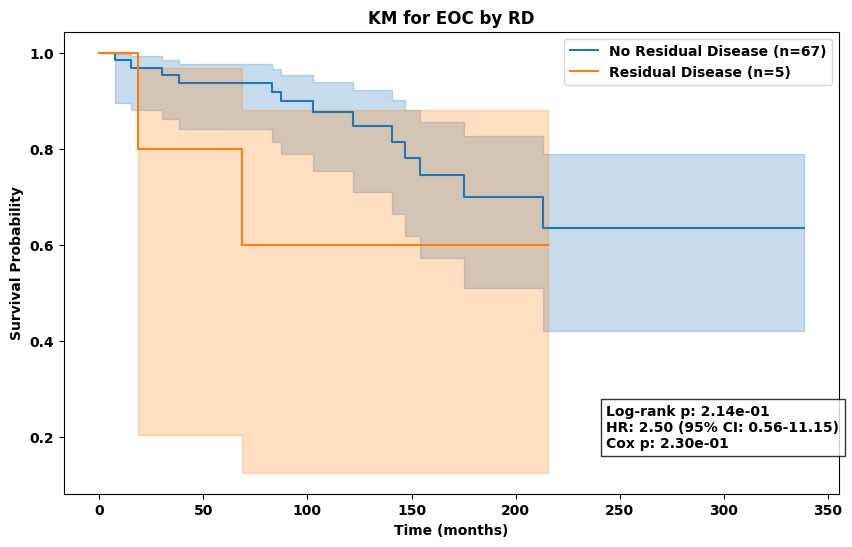

In [13]:
### ### SURVIVAL ANALYSIS FOR EOC BY RESIDUAL DISEASE ##########################

# Uncomment to import if not previously done
#from lifelines import KaplanMeierFitter, CoxPHFitter
#from lifelines.statistics import logrank_test
# import pandas as pd
#import matplotlib.pyplot as plt

# Filter for EOC samples and drop NaN values
df_eoc = df_variables[(df_variables['HISTOLOGY_LABEL'] == 'EOC')].dropna(subset=['VITAL STATUS', 'OS_MONTHS', 'RESIDUALa']).copy()

# Convert columns to numeric
df_eoc['OS_MONTHS'] = pd.to_numeric(df_eoc['OS_MONTHS'], errors='coerce')
df_eoc['VITAL STATUS'] = pd.to_numeric(df_eoc['VITAL STATUS'], errors='coerce')
df_eoc['RESIDUALa'] = pd.to_numeric(df_eoc['RESIDUALa'], errors='coerce')

# Separate into RESIDUALa groups (0 = No Residual, 1 = Residual)
df_no_residual = df_eoc[df_eoc['RESIDUALa'] == 0]
df_residual = df_eoc[df_eoc['RESIDUALa'] == 1]

# Perform Cox proportional hazards model
cox_data = df_eoc[['OS_MONTHS', 'VITAL STATUS', 'RESIDUALa']].copy()
cox_data.rename(columns={'OS_MONTHS': 'duration', 'VITAL STATUS': 'event'}, inplace=True)

cox_model = CoxPHFitter()
cox_model.fit(cox_data, duration_col='duration', event_col='event')

# Extract results from Cox model
cox_summary = cox_model.summary.loc['RESIDUALa']
hr = cox_summary['exp(coef)']
hr_lower = cox_summary['exp(coef) lower 95%']
hr_upper = cox_summary['exp(coef) upper 95%']
cox_p_value = cox_summary['p']

# Initialize Kaplan-Meier fitters
kmf_no_residual = KaplanMeierFitter()
kmf_residual = KaplanMeierFitter()

# Plot survival curves
plt.figure(figsize=(10, 6))

kmf_no_residual.fit(durations=df_no_residual['OS_MONTHS'], 
                    event_observed=df_no_residual['VITAL STATUS'], 
                    label=f"No Residual Disease (n={len(df_no_residual)})")
ax = kmf_no_residual.plot_survival_function(ci_show=True)

kmf_residual.fit(durations=df_residual['OS_MONTHS'], 
                 event_observed=df_residual['VITAL STATUS'], 
                 label=f"Residual Disease (n={len(df_residual)})")
kmf_residual.plot_survival_function(ax=ax, ci_show=True)

# Perform log-rank test
logrank_results = logrank_test(df_no_residual['OS_MONTHS'], df_residual['OS_MONTHS'],
                               event_observed_A=df_no_residual['VITAL STATUS'],
                               event_observed_B=df_residual['VITAL STATUS'])

logrank_p_value = logrank_results.p_value

# Annotate the plot with log-rank p-value, HR, and CI from Cox model
plt.text(0.7, 0.1, f"Log-rank p: {logrank_p_value:.2e}\n"
                   f"HR: {hr:.2f} (95% CI: {hr_lower:.2f}-{hr_upper:.2f})\n"
                   f"Cox p: {cox_p_value:.2e}",fontweight='bold',
         transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# Finalize plot
plt.title("KM for EOC by RD", fontweight='bold')
plt.xlabel("Time (months)", fontweight='bold')
plt.ylabel("Survival Probability",fontweight='bold')
# Set axis tick labels to bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

# Update legend with bold text
plt.legend(fontsize=10, title_fontsize=10, prop={'weight': 'bold'})

# Show
plt.show()


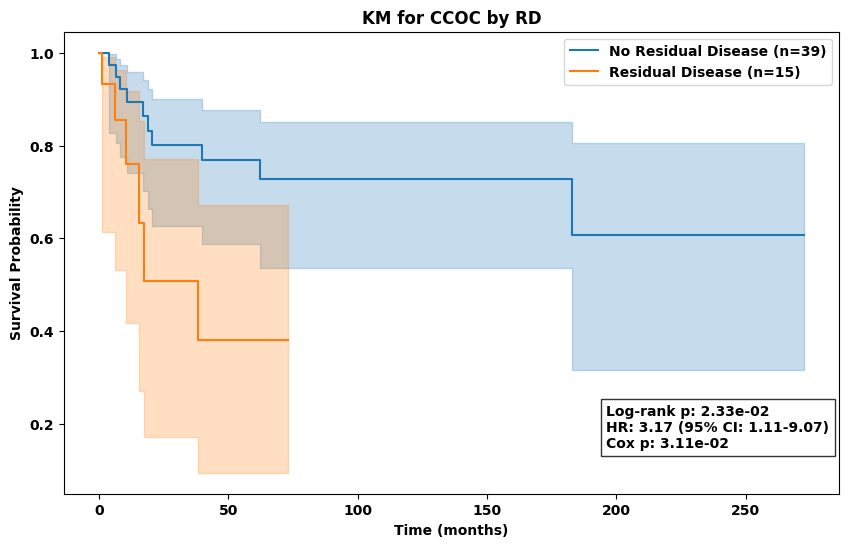

In [14]:
### SURVIVAL ANALYSIS FOR CCOC BY RESIDUAL DISEASE  ############

# Uncomment to import if not previously done
#from lifelines import KaplanMeierFitter, CoxPHFitter
#from lifelines.statistics import logrank_test
# import pandas as pd
#import matplotlib.pyplot as plt

# Filter for CCOC samples and drop NaN values
df_ccoc = df_variables[(df_variables['HISTOLOGY_LABEL'] == 'CCOC')].dropna(subset=['VITAL STATUS', 'OS_MONTHS', 'RESIDUALa']).copy()

# Convert columns to numeric
df_ccoc['OS_MONTHS'] = pd.to_numeric(df_ccoc['OS_MONTHS'], errors='coerce')
df_ccoc['VITAL STATUS'] = pd.to_numeric(df_ccoc['VITAL STATUS'], errors='coerce')
df_ccoc['RESIDUALa'] = pd.to_numeric(df_ccoc['RESIDUALa'], errors='coerce')

# Separate into RESIDUALa groups (0 = No Residual, 1 = Residual)
df_no_residual = df_ccoc[df_ccoc['RESIDUALa'] == 0]
df_residual = df_ccoc[df_ccoc['RESIDUALa'] == 1]

# Perform Cox proportional hazards model
cox_data = df_ccoc[['OS_MONTHS', 'VITAL STATUS', 'RESIDUALa']].copy()
cox_data.rename(columns={'OS_MONTHS': 'duration', 'VITAL STATUS': 'event'}, inplace=True)

cox_model = CoxPHFitter()
cox_model.fit(cox_data, duration_col='duration', event_col='event')

# Extract results from Cox model
cox_summary = cox_model.summary.loc['RESIDUALa']
hr = cox_summary['exp(coef)']
hr_lower = cox_summary['exp(coef) lower 95%']
hr_upper = cox_summary['exp(coef) upper 95%']
cox_p_value = cox_summary['p']

# Initialize Kaplan-Meier fitters
kmf_no_residual = KaplanMeierFitter()
kmf_residual = KaplanMeierFitter()

# Plot survival curves
plt.figure(figsize=(10, 6))

kmf_no_residual.fit(durations=df_no_residual['OS_MONTHS'], 
                    event_observed=df_no_residual['VITAL STATUS'], 
                    label=f"No Residual Disease (n={len(df_no_residual)})")
ax = kmf_no_residual.plot_survival_function(ci_show=True)

kmf_residual.fit(durations=df_residual['OS_MONTHS'], 
                 event_observed=df_residual['VITAL STATUS'], 
                 label=f"Residual Disease (n={len(df_residual)})")
kmf_residual.plot_survival_function(ax=ax, ci_show=True)

# Perform log-rank test
logrank_results = logrank_test(df_no_residual['OS_MONTHS'], df_residual['OS_MONTHS'],
                               event_observed_A=df_no_residual['VITAL STATUS'],
                               event_observed_B=df_residual['VITAL STATUS'])

logrank_p_value = logrank_results.p_value

# Annotate the plot with log-rank p-value, HR, and CI from Cox model
plt.text(0.7, 0.1, f"Log-rank p: {logrank_p_value:.2e}\n"
                   f"HR: {hr:.2f} (95% CI: {hr_lower:.2f}-{hr_upper:.2f})\n"
                   f"Cox p: {cox_p_value:.2e}",fontweight='bold',
         transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# Finalize plot
plt.title("KM for CCOC by RD", fontweight='bold')
plt.xlabel("Time (months)",fontweight='bold')
plt.ylabel("Survival Probability",fontweight='bold')

# Set axis tick labels to bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

# Update legend with bold text
plt.legend(fontsize=10, title_fontsize=10, prop={'weight': 'bold'})

# Show
plt.show()

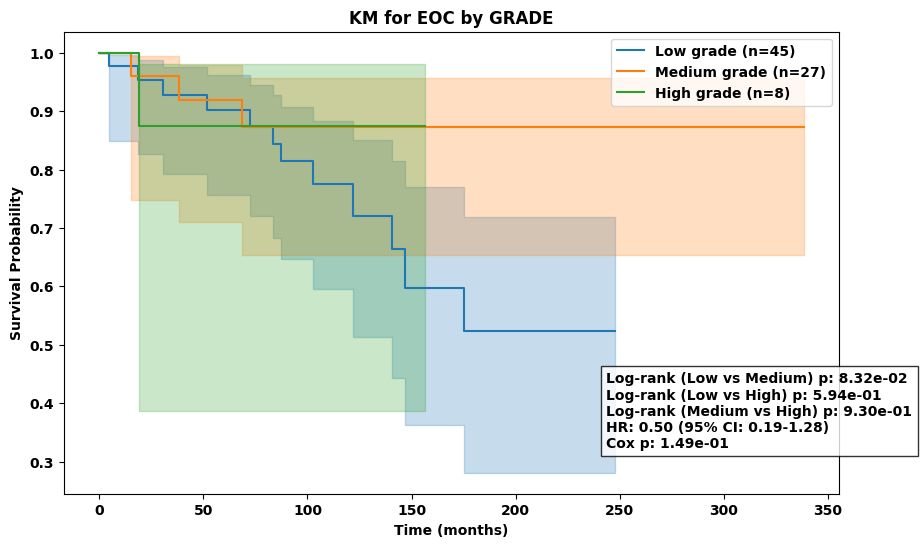

In [15]:
# SURVIVAL ANALYSIS FOR EOC BY GRADE ############

# Uncomment to import if not previously done
#from lifelines import KaplanMeierFitter, CoxPHFitter
#from lifelines.statistics import logrank_test
# import pandas as pd
#import matplotlib.pyplot as plt

# Filter data for EOC and drop rows with missing values
df_eoc = df_variables[(df_variables['HISTOLOGY_LABEL'] == 'EOC')].dropna(subset=['VITAL STATUS', 'OS_MONTHS', 'GRADE']).copy()

# Convert columns to numeric type explicitly
df_eoc['OS_MONTHS'] = pd.to_numeric(df_eoc['OS_MONTHS'], errors='coerce')
df_eoc['VITAL STATUS'] = pd.to_numeric(df_eoc['VITAL STATUS'], errors='coerce')
df_eoc['GRADE'] = pd.to_numeric(df_eoc['GRADE'], errors='coerce')

# Map GRADE values to more readable labels
df_eoc['GRADE_LABEL'] = df_eoc['GRADE'].map({
    1: 'Low grade',
    2: 'Medium grade',
    3: 'High grade'
})

# Separate data into three groups based on GRADE
df_grade_1 = df_eoc[df_eoc['GRADE'] == 1]
df_grade_2 = df_eoc[df_eoc['GRADE'] == 2]
df_grade_3 = df_eoc[df_eoc['GRADE'] == 3]

# Cox Proportional Hazards Model for GRADE
cox_data = df_eoc[['OS_MONTHS', 'VITAL STATUS', 'GRADE']].copy()
cox_data.rename(columns={'OS_MONTHS': 'duration', 'VITAL STATUS': 'event'}, inplace=True)

cox_model = CoxPHFitter()
cox_model.fit(cox_data, duration_col='duration', event_col='event')

# Extract Cox model results for GRADE
cox_summary = cox_model.summary.loc['GRADE']
hr = cox_summary['exp(coef)']  # Hazard Ratio
hr_lower = cox_summary['exp(coef) lower 95%']  # Lower bound of 95% CI
hr_upper = cox_summary['exp(coef) upper 95%']  # Upper bound of 95% CI
cox_p_value = cox_summary['p']  # p-value for GRADE

# Initialize Kaplan-Meier fitters for each grade
kmf_grade_1 = KaplanMeierFitter()
kmf_grade_2 = KaplanMeierFitter()
kmf_grade_3 = KaplanMeierFitter()

# Plot survival curves
plt.figure(figsize=(10, 6))

# Kaplan-Meier curve for Low grade
kmf_grade_1.fit(durations=df_grade_1['OS_MONTHS'], 
                event_observed=df_grade_1['VITAL STATUS'], 
                label=f"Low grade (n={len(df_grade_1)})")
ax = kmf_grade_1.plot_survival_function(ci_show=True)

# Kaplan-Meier curve for Medium grade
kmf_grade_2.fit(durations=df_grade_2['OS_MONTHS'], 
                event_observed=df_grade_2['VITAL STATUS'], 
                label=f"Medium grade (n={len(df_grade_2)})")
kmf_grade_2.plot_survival_function(ax=ax, ci_show=True)

# Kaplan-Meier curve for High grade
kmf_grade_3.fit(durations=df_grade_3['OS_MONTHS'], 
                event_observed=df_grade_3['VITAL STATUS'], 
                label=f"High grade (n={len(df_grade_3)})")
kmf_grade_3.plot_survival_function(ax=ax, ci_show=True)

# Perform log-rank tests between the groups
logrank_results_12 = logrank_test(df_grade_1['OS_MONTHS'], df_grade_2['OS_MONTHS'],
                                  event_observed_A=df_grade_1['VITAL STATUS'],
                                  event_observed_B=df_grade_2['VITAL STATUS'])

logrank_results_13 = logrank_test(df_grade_1['OS_MONTHS'], df_grade_3['OS_MONTHS'],
                                  event_observed_A=df_grade_1['VITAL STATUS'],
                                  event_observed_B=df_grade_3['VITAL STATUS'])

logrank_results_23 = logrank_test(df_grade_2['OS_MONTHS'], df_grade_3['OS_MONTHS'],
                                  event_observed_A=df_grade_2['VITAL STATUS'],
                                  event_observed_B=df_grade_3['VITAL STATUS'])

# Extract log-rank test p-values
logrank_p_value_12 = logrank_results_12.p_value
logrank_p_value_13 = logrank_results_13.p_value
logrank_p_value_23 = logrank_results_23.p_value

# Annotate the plot with log-rank p-values, HR, and CI from Cox model
plt.text(0.7, 0.1, f"Log-rank (Low vs Medium) p: {logrank_p_value_12:.2e}\n"
                   f"Log-rank (Low vs High) p: {logrank_p_value_13:.2e}\n"
                   f"Log-rank (Medium vs High) p: {logrank_p_value_23:.2e}\n"
                   f"HR: {hr:.2f} (95% CI: {hr_lower:.2f}-{hr_upper:.2f})\n"
                   f"Cox p: {cox_p_value:.2e}", fontweight='bold',
         transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# Finalize the plot
plt.title("KM for EOC by GRADE", fontweight='bold')  # Bold title
plt.xlabel("Time (months)", fontweight='bold')  # Bold X-axis label
plt.ylabel("Survival Probability", fontweight='bold')  # Bold Y-axis label

# Update axes tick labels to bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

# Update legend with bold text
plt.legend(fontsize=10, title_fontsize=10, prop={'weight': 'bold'})

# Show
plt.show()


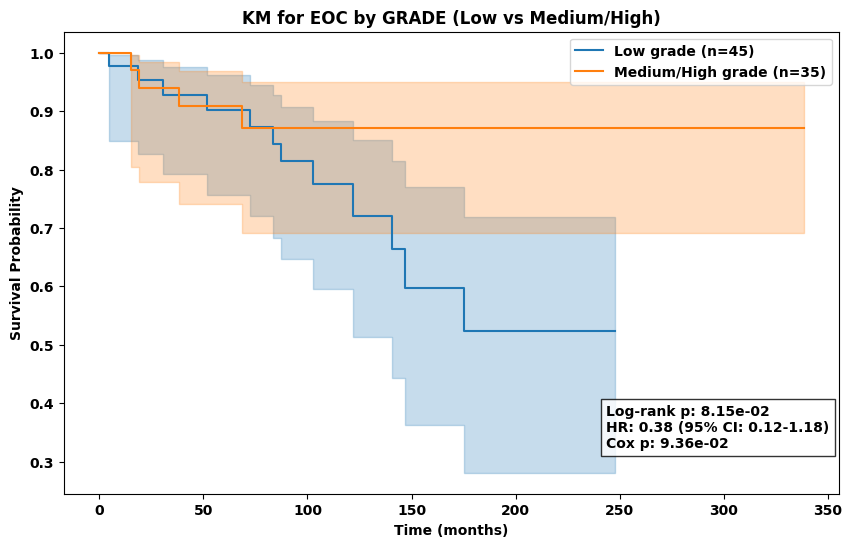

In [16]:
# SURVIVAL ANALYSIS FOR EOC BY GRADE AFTER GROUPING MEDIUM (GRADE 2) AND HIGH (GRADE 3) GRADE CATEGORIES ############

# Uncomment to import if not previously done
#from lifelines import KaplanMeierFitter, CoxPHFitter
#from lifelines.statistics import logrank_test
# import pandas as pd
#import matplotlib.pyplot as plt

# Filter data for EOC and remove rows with missing values
df_eoc = df_variables[(df_variables['HISTOLOGY_LABEL'] == 'EOC')].dropna(subset=['VITAL STATUS', 'OS_MONTHS', 'GRADE']).copy()

# Convert columns to numeric type explicitly
df_eoc['OS_MONTHS'] = pd.to_numeric(df_eoc['OS_MONTHS'], errors='coerce')
df_eoc['VITAL STATUS'] = pd.to_numeric(df_eoc['VITAL STATUS'], errors='coerce')
df_eoc['GRADE'] = pd.to_numeric(df_eoc['GRADE'], errors='coerce')

# Create a new column to group GRADE 2 and 3 into a single category
df_eoc['GRADE_GROUPED'] = df_eoc['GRADE'].apply(lambda x: 2 if x >= 2 else 1)  # 1 for GRADE 1, 2 for GRADE 2 and 3
df_eoc['GRADE_LABEL'] = df_eoc['GRADE_GROUPED'].map({
    1: 'Low grade',
    2: 'Medium/High grade'
})

# Separate data into two groups based on GRADE_GROUPED
df_grade_1 = df_eoc[df_eoc['GRADE_GROUPED'] == 1]
df_grade_2_3 = df_eoc[df_eoc['GRADE_GROUPED'] == 2]

# Perform Cox Proportional Hazards Model for GRADE (1 vs 2/3)
cox_data = df_eoc[['OS_MONTHS', 'VITAL STATUS', 'GRADE_GROUPED']].copy()
cox_data.rename(columns={'OS_MONTHS': 'duration', 'VITAL STATUS': 'event'}, inplace=True)

cox_model = CoxPHFitter()
cox_model.fit(cox_data, duration_col='duration', event_col='event')

# Extract results from the Cox model
cox_summary = cox_model.summary.loc['GRADE_GROUPED']
hr = cox_summary['exp(coef)']  # Hazard Ratio
hr_lower = cox_summary['exp(coef) lower 95%']  # Lower bound of 95% CI
hr_upper = cox_summary['exp(coef) upper 95%']  # Upper bound of 95% CI
cox_p_value = cox_summary['p']  # p-value for GRADE_GROUPED

# Initialize Kaplan-Meier fitters for each grade group
kmf_grade_1 = KaplanMeierFitter()
kmf_grade_2_3 = KaplanMeierFitter()

# Plot survival curves
plt.figure(figsize=(10, 6))

# Kaplan-Meier curve for Low grade
kmf_grade_1.fit(durations=df_grade_1['OS_MONTHS'], 
                event_observed=df_grade_1['VITAL STATUS'], 
                label=f"Low grade (n={len(df_grade_1)})")
ax = kmf_grade_1.plot_survival_function(ci_show=True)

# Kaplan-Meier curve for Medium/High grade
kmf_grade_2_3.fit(durations=df_grade_2_3['OS_MONTHS'], 
                  event_observed=df_grade_2_3['VITAL STATUS'], 
                  label=f"Medium/High grade (n={len(df_grade_2_3)})")
kmf_grade_2_3.plot_survival_function(ax=ax, ci_show=True)

# Perform log-rank test
logrank_results = logrank_test(df_grade_1['OS_MONTHS'], df_grade_2_3['OS_MONTHS'],
                               event_observed_A=df_grade_1['VITAL STATUS'],
                               event_observed_B=df_grade_2_3['VITAL STATUS'])

logrank_p_value = logrank_results.p_value

# Annotate the plot with log-rank p-value, HR, and CI from Cox model
plt.text(0.7, 0.1, f"Log-rank p: {logrank_p_value:.2e}\n"
                   f"HR: {hr:.2f} (95% CI: {hr_lower:.2f}-{hr_upper:.2f})\n"
                   f"Cox p: {cox_p_value:.2e}", fontweight='bold',
         transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# Finalize the plot
plt.title("KM for EOC by GRADE (Low vs Medium/High)", fontweight='bold')  # Bold title
plt.xlabel("Time (months)", fontweight='bold')  # Bold X-axis label
plt.ylabel("Survival Probability", fontweight='bold')  # Bold Y-axis label

# Update axes tick labels to bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

# Update legend with bold text
plt.legend(fontsize=10, title_fontsize=10, prop={'weight': 'bold'})

# Show
plt.show()


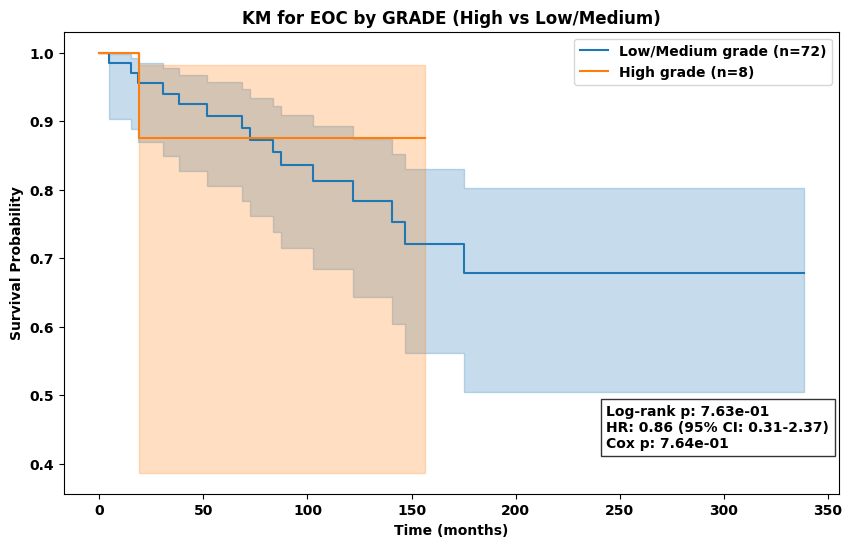

In [17]:
# SURVIVAL ANALYSIS FOR EOC BY GRADE AFTER GROUPING MEDIUM (GRADE 2) AND LOW (GRADE 1) GRADE CATEGORIES ############

# Uncomment to import if not previously done
#from lifelines import KaplanMeierFitter, CoxPHFitter
#from lifelines.statistics import logrank_test
# import pandas as pd
#import matplotlib.pyplot as plt

# Filter data for EOC (Epithelial Ovarian Cancer) and remove rows with missing values
df_eoc = df_variables[(df_variables['HISTOLOGY_LABEL'] == 'EOC')].dropna(subset=['VITAL STATUS', 'OS_MONTHS', 'GRADE']).copy()

# Convert columns to numeric type explicitly
df_eoc['OS_MONTHS'] = pd.to_numeric(df_eoc['OS_MONTHS'], errors='coerce')
df_eoc['VITAL STATUS'] = pd.to_numeric(df_eoc['VITAL STATUS'], errors='coerce')
df_eoc['GRADE'] = pd.to_numeric(df_eoc['GRADE'], errors='coerce')

# Create a new column to group Grades 1 and 2 together as "Low/Medium grade" and keep Grade 3 as "High grade"
df_eoc['GRADE_GROUPED'] = df_eoc['GRADE'].apply(lambda x: 1 if x == 1 or x == 2 else 3)
df_eoc['GRADE_LABEL'] = df_eoc['GRADE_GROUPED'].map({
    1: 'Low/Medium grade',
    3: 'High grade'
})

# Separate data into two groups: Low/Medium grade (Grades 1 and 2) and High grade (Grade 3)
df_group_1_2 = df_eoc[df_eoc['GRADE_GROUPED'] == 1]
df_group_3 = df_eoc[df_eoc['GRADE_GROUPED'] == 3]

# Perform Cox Proportional Hazards Model for grouped GRADE (Low/Medium vs High)
cox_data = df_eoc[['OS_MONTHS', 'VITAL STATUS', 'GRADE_GROUPED']].copy()
cox_data.rename(columns={'OS_MONTHS': 'duration', 'VITAL STATUS': 'event'}, inplace=True)

cox_model = CoxPHFitter()
cox_model.fit(cox_data, duration_col='duration', event_col='event')

# Extract results from the Cox model for grouped GRADE
cox_summary = cox_model.summary.loc['GRADE_GROUPED']
hr = cox_summary['exp(coef)']  # Hazard Ratio
hr_lower = cox_summary['exp(coef) lower 95%']  # Lower bound of 95% CI
hr_upper = cox_summary['exp(coef) upper 95%']  # Upper bound of 95% CI
cox_p_value = cox_summary['p']  # p-value for GRADE_GROUPED

# Initialize Kaplan-Meier fitters for each grade group
kmf_group_1_2 = KaplanMeierFitter()
kmf_group_3 = KaplanMeierFitter()

# Plot survival curves
plt.figure(figsize=(10, 6))

# Kaplan-Meier curve for Low/Medium grade (Grades 1 & 2)
kmf_group_1_2.fit(durations=df_group_1_2['OS_MONTHS'], 
                  event_observed=df_group_1_2['VITAL STATUS'], 
                  label=f"Low/Medium grade (n={len(df_group_1_2)})")
ax = kmf_group_1_2.plot_survival_function(ci_show=True)

# Kaplan-Meier curve for High grade (Grade 3)
kmf_group_3.fit(durations=df_group_3['OS_MONTHS'], 
                event_observed=df_group_3['VITAL STATUS'], 
                label=f"High grade (n={len(df_group_3)})")
kmf_group_3.plot_survival_function(ax=ax, ci_show=True)

# Perform log-rank test between groups (Low/Medium vs High)
logrank_results = logrank_test(df_group_1_2['OS_MONTHS'], df_group_3['OS_MONTHS'],
                               event_observed_A=df_group_1_2['VITAL STATUS'],
                               event_observed_B=df_group_3['VITAL STATUS'])

logrank_p_value = logrank_results.p_value

# Annotate the plot with log-rank p-value, HR, and CI from Cox model
plt.text(0.7, 0.1, f"Log-rank p: {logrank_p_value:.2e}\n"
                   f"HR: {hr:.2f} (95% CI: {hr_lower:.2f}-{hr_upper:.2f})\n"
                   f"Cox p: {cox_p_value:.2e}", fontweight='bold',
         transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# Finalize the plot
plt.title("KM for EOC by GRADE (High vs Low/Medium)", fontweight='bold')  # Bold title
plt.xlabel("Time (months)", fontweight='bold')  # Bold X-axis label
plt.ylabel("Survival Probability", fontweight='bold')  # Bold Y-axis label

# Update axes tick labels to bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

# Update legend with bold text
plt.legend(fontsize=10, title_fontsize=10, prop={'weight': 'bold'})

# Show
plt.show()


In [18]:
## PREPARE DATA FOR MULTIVARIATE ANALYSIS ########
# Convert to categoric variables 
df_eoc['FIGOL'] = df_eoc['FIGOL'].astype('category')
df_eoc['GRADE'] = df_eoc['GRADE'].astype('category')
df_eoc['RESIDUALa'] = df_eoc['RESIDUALa'].astype('category')

# Verify reference categories
print("Categoría de referencia de FIGOL:", df_eoc['FIGOL'].cat.categories[0]) #It must be the 0 or Localized
print("Categoría de referencia de GRADE:", df_eoc['GRADE'].cat.categories[0]) #It must be grade 1 or well differentiated
print("Categoría de referencia de RESIDUALa:", df_eoc['RESIDUALa'].cat.categories[0]) # It must be the 0= No

Categoría de referencia de FIGOL: 0
Categoría de referencia de GRADE: 1
Categoría de referencia de RESIDUALa: 0


In [19]:
#### MULTIVARIATE ANALYSIS USING COX PROPORTIONAL HAZARDS MODELS ########### 

# Uncomment to import if not previously done
# from lifelines import  CoxPHFittert
# import pandas as pd


# Filter data for HISTOLOGY = CCOC and EOC and drop rows with missing values
df_ccoc = df_variables[df_variables['HISTOLOGY_LABEL'] == 'CCOC'].dropna(subset=['VITAL STATUS', 'OS_MONTHS', 'AGE', 'FIGOL', 'RESIDUALa'])
df_eoc = df_variables[df_variables['HISTOLOGY_LABEL'] == 'EOC'].dropna(subset=['VITAL STATUS', 'OS_MONTHS', 'AGE', 'FIGOL', 'RESIDUALa', 'GRADE'])

# Ensure OS_MONTHS and VITAL STATUS columns are numeric
df_ccoc['OS_MONTHS'] = pd.to_numeric(df_ccoc['OS_MONTHS'], errors='coerce')
df_ccoc['VITAL STATUS'] = pd.to_numeric(df_ccoc['VITAL STATUS'], errors='coerce')

df_eoc['OS_MONTHS'] = pd.to_numeric(df_eoc['OS_MONTHS'], errors='coerce')
df_eoc['VITAL STATUS'] = pd.to_numeric(df_eoc['VITAL STATUS'], errors='coerce')

# Convert categorical variables into dummies for Cox analysis
# Keep 'AGE' as a continuous variable, and convert 'FIGOL', 'RESIDUALa', and 'GRADE' into dummy variables
df_ccoc_dummies = pd.get_dummies(df_ccoc[['FIGOL', 'RESIDUALa']], drop_first=True)
df_eoc_dummies = pd.get_dummies(df_eoc[['FIGOL', 'RESIDUALa', 'GRADE']], drop_first=True)

# Concatenate survival time and event variables with the dummy variables
df_ccoc_final = pd.concat([df_ccoc[['OS_MONTHS', 'VITAL STATUS', 'AGE']], df_ccoc_dummies], axis=1)
df_eoc_final = pd.concat([df_eoc[['OS_MONTHS', 'VITAL STATUS', 'AGE']], df_eoc_dummies], axis=1)

# Multivariate Cox analysis for HISTOLOGY = CCOC
cox_model_ccoc = CoxPHFitter()
cox_model_ccoc.fit(df_ccoc_final, duration_col='OS_MONTHS', event_col='VITAL STATUS')

# Print Cox model results for CCOC
print("Cox analysis results for HISTOLOGY = CCOC:")
print(cox_model_ccoc.summary)

# Multivariate Cox analysis for HISTOLOGY = EOC
cox_model_eoc = CoxPHFitter()
cox_model_eoc.fit(df_eoc_final, duration_col='OS_MONTHS', event_col='VITAL STATUS')

# Print Cox model results for EOC
print("\nCox analysis results for HISTOLOGY = EOC:")
print(cox_model_eoc.summary)

Cox analysis results for HISTOLOGY = CCOC:
                 coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                    
AGE          0.036313   1.036980  0.024660       -0.012019        0.084645   
FIGOL_1      1.777404   5.914485  0.642865        0.517412        3.037397   
RESIDUALa_1  0.704921   2.023688  0.616173       -0.502756        1.912599   

             exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                 
AGE                     0.988053             1.088330     0.0  1.472570   
FIGOL_1                 1.677680            20.850899     0.0  2.764817   
RESIDUALa_1             0.604861             6.770663     0.0  1.144031   

                    p  -log2(p)  
covariate                        
AGE          0.140867  2.827595  
FIGOL_1      0.005695  7.455968  
RESIDUALa_1  0.252611  1.985011  

Cox analysis result

/home/vant/miniforge3/lib/python3.10/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column GRADE_3 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['VITAL STATUS'].astype(bool)
>>> print(df.loc[events, 'GRADE_3'].var())
>>> print(df.loc[~events, 'GRADE_3'].var())

A very low variance means that the column GRADE_3 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/vant/miniforge3/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.308. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearit

In [20]:
## The warning indicates that the column GRADE_3 has very low variance conditioned on the event status, potentially leading 
## to complete separation. This means that GRADE_3 might perfectly predict whether a subject dies or not, causing issues with model
## convergence and resulting in non-unique solutions.

## Check if there is some correlation between the variables
print(df_eoc[['FIGOL', 'RESIDUALa', 'GRADE']].corr()) ##### No correlations
## Verify grade 3 distribution 
print(df_eoc.groupby('GRADE')['VITAL STATUS'].value_counts()) ### All grade 3 patients in EOC are alive (7)

              FIGOL  RESIDUALa     GRADE
FIGOL      1.000000   0.054690  0.066734
RESIDUALa  0.054690   1.000000  0.188255
GRADE      0.066734   0.188255  1.000000
GRADE  VITAL STATUS
1      0               28
       1                9
2      0               20
       1                3
3      0                7
Name: count, dtype: int64


In [21]:
### MULTIVARIATE COX MODEL AFTER GROUPING GRADE PROBLEMATIC CATEGORIES FOR EOC ############
from lifelines import CoxPHFitter
import pandas as pd

# Filter data for HISTOLOGY = EOC and CCOC, removing rows with missing values
df_ccoc = df_variables[df_variables['HISTOLOGY_LABEL'] == 'CCOC'].dropna(subset=['VITAL STATUS', 'OS_MONTHS', 'AGE', 'FIGOL', 'RESIDUALa'])
df_eoc = df_variables[df_variables['HISTOLOGY_LABEL'] == 'EOC'].dropna(subset=['VITAL STATUS', 'OS_MONTHS', 'AGE', 'FIGOL', 'RESIDUALa', 'GRADE'])

# Remove rows with negative values in 'OS_MONTHS' (time to event cannot be negative)
df_ccoc = df_ccoc[df_ccoc['OS_MONTHS'] >= 0]
df_eoc = df_eoc[df_eoc['OS_MONTHS'] >= 0]

# Explicitly convert columns to numeric types
df_ccoc['OS_MONTHS'] = pd.to_numeric(df_ccoc['OS_MONTHS'], errors='coerce')
df_ccoc['VITAL STATUS'] = pd.to_numeric(df_ccoc['VITAL STATUS'], errors='coerce')
df_eoc['OS_MONTHS'] = pd.to_numeric(df_eoc['OS_MONTHS'], errors='coerce')
df_eoc['VITAL STATUS'] = pd.to_numeric(df_eoc['VITAL STATUS'], errors='coerce')

# Create a new column to group GRADE 2 and 3 into a single category
# Assign 1 for GRADE 1, and 2 for GRADE 2 and 3
df_eoc['GRADE_GROUPED'] = df_eoc['GRADE'].apply(lambda x: 2 if x >= 2 else 1)

# Convert categorical variables to dummy variables for analysis
df_ccoc_dummies = pd.get_dummies(df_ccoc[['FIGOL', 'RESIDUALa']], drop_first=True)
df_eoc_dummies = pd.get_dummies(df_eoc[['FIGOL', 'RESIDUALa', 'GRADE_GROUPED']], drop_first=True)

# Combine survival time, event columns, and dummy variables
df_ccoc_final = pd.concat([df_ccoc[['OS_MONTHS', 'VITAL STATUS', 'AGE']], df_ccoc_dummies], axis=1)
df_eoc_final = pd.concat([df_eoc[['OS_MONTHS', 'VITAL STATUS', 'AGE']], df_eoc_dummies], axis=1)

# Ensure there are no missing values in the necessary columns
df_ccoc_final = df_ccoc_final.dropna(subset=['OS_MONTHS', 'VITAL STATUS', 'AGE'])
df_eoc_final = df_eoc_final.dropna(subset=['OS_MONTHS', 'VITAL STATUS', 'AGE'])

# Check if any columns have non-numeric values
print(df_ccoc_final.dtypes)
print(df_eoc_final.dtypes)

# Multivariate Cox proportional hazards analysis for HISTOLOGY = CCOC
cox_model_ccoc = CoxPHFitter()
cox_model_ccoc.fit(df_ccoc_final, duration_col='OS_MONTHS', event_col='VITAL STATUS')

# Print the results of the model for CCOC
print("Cox model results for HISTOLOGY = CCOC:")
print(cox_model_ccoc.summary)

# Multivariate Cox proportional hazards analysis for HISTOLOGY = EOC
cox_model_eoc = CoxPHFitter()
cox_model_eoc.fit(df_eoc_final, duration_col='OS_MONTHS', event_col='VITAL STATUS')

# Print the results of the model for EOC
print("\nCox model results for HISTOLOGY = EOC:")
print(cox_model_eoc.summary)

OS_MONTHS       float64
VITAL STATUS      int64
AGE              object
FIGOL_1            bool
RESIDUALa_1        bool
dtype: object
OS_MONTHS        float64
VITAL STATUS       int64
AGE               object
GRADE_GROUPED      int64
FIGOL_1             bool
RESIDUALa_1         bool
dtype: object
Cox model results for HISTOLOGY = CCOC:
                 coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                    
AGE          0.036313   1.036980  0.024660       -0.012019        0.084645   
FIGOL_1      1.777404   5.914485  0.642865        0.517412        3.037397   
RESIDUALa_1  0.704921   2.023688  0.616173       -0.502756        1.912599   

             exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                 
AGE                     0.988053             1.088330     0.0  1.472570   
FIGOL_1                 1.677680            20

In [22]:
### MULTIVARIATE COX MODEL AFTER GROUPING GRADE PROBLEMATIC CATEGORIES FOR EOC ############

# Filter data for HISTOLOGY = EOC and CCOC, removing rows with missing values
df_ccoc = df_variables[df_variables['HISTOLOGY_LABEL'] == 'CCOC'].dropna(subset=['VITAL STATUS', 'OS_MONTHS', 'AGE', 'FIGOL', 'RESIDUALa'])
df_eoc = df_variables[df_variables['HISTOLOGY_LABEL'] == 'EOC'].dropna(subset=['VITAL STATUS', 'OS_MONTHS', 'AGE', 'FIGOL', 'RESIDUALa', 'GRADE'])

# Remove rows with negative values in 'OS_MONTHS' (invalid survival times)
df_ccoc = df_ccoc[df_ccoc['OS_MONTHS'] >= 0]
df_eoc = df_eoc[df_eoc['OS_MONTHS'] >= 0]

# Convert to numeric
df_ccoc['OS_MONTHS'] = pd.to_numeric(df_ccoc['OS_MONTHS'], errors='coerce')
df_ccoc['VITAL STATUS'] = pd.to_numeric(df_ccoc['VITAL STATUS'], errors='coerce')
df_eoc['OS_MONTHS'] = pd.to_numeric(df_eoc['OS_MONTHS'], errors='coerce')
df_eoc['VITAL STATUS'] = pd.to_numeric(df_eoc['VITAL STATUS'], errors='coerce')

# Create a new column to group GRADE categories
df_eoc['GRADE_GROUPED'] = df_eoc['GRADE'].apply(lambda x: 2 if x >= 2 else 1)  # 1 para GRADE 1, 2 para GRADE 2 y 3

# Convert categorical variables to dummy variables
df_ccoc_dummies = pd.get_dummies(df_ccoc[['FIGOL', 'RESIDUALa']], drop_first=True)
df_eoc_dummies = pd.get_dummies(df_eoc[['FIGOL', 'RESIDUALa', 'GRADE_GROUPED']], drop_first=True)

# Combine survival time, event columns, and dummy variables
df_ccoc_final = pd.concat([df_ccoc[['OS_MONTHS', 'VITAL STATUS', 'AGE']], df_ccoc_dummies], axis=1)
df_eoc_final = pd.concat([df_eoc[['OS_MONTHS', 'VITAL STATUS', 'AGE']], df_eoc_dummies], axis=1)

# Ensure there are no missing values in the necessary columns
df_ccoc_final = df_ccoc_final.dropna(subset=['OS_MONTHS', 'VITAL STATUS', 'AGE'])
df_eoc_final = df_eoc_final.dropna(subset=['OS_MONTHS', 'VITAL STATUS', 'AGE'])

# Verify
print(df_ccoc_final.dtypes)
print(df_eoc_final.dtypes)

# Multivariate Cox proportional hazards analysis for HISTOLOGY = CCOC
cox_model_ccoc = CoxPHFitter()
cox_model_ccoc.fit(df_ccoc_final, duration_col='OS_MONTHS', event_col='VITAL STATUS')

# Print results
print("Resultados del análisis de Cox para HISTOLOGY = CCOC:")
print(cox_model_ccoc.summary)

# Multivariate Cox proportional hazards analysis for HISTOLOGY = EOC
cox_model_eoc = CoxPHFitter()
cox_model_eoc.fit(df_eoc_final, duration_col='OS_MONTHS', event_col='VITAL STATUS')

# Print results
print("\nResultados del análisis de Cox para HISTOLOGY = EOC:")
print(cox_model_eoc.summary)


OS_MONTHS       float64
VITAL STATUS      int64
AGE              object
FIGOL_1            bool
RESIDUALa_1        bool
dtype: object
OS_MONTHS        float64
VITAL STATUS       int64
AGE               object
GRADE_GROUPED      int64
FIGOL_1             bool
RESIDUALa_1         bool
dtype: object
Resultados del análisis de Cox para HISTOLOGY = CCOC:
                 coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                    
AGE          0.036313   1.036980  0.024660       -0.012019        0.084645   
FIGOL_1      1.777404   5.914485  0.642865        0.517412        3.037397   
RESIDUALa_1  0.704921   2.023688  0.616173       -0.502756        1.912599   

             exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                 
AGE                     0.988053             1.088330     0.0  1.472570   
FIGOL_1                 1.677680

In [23]:
### MULTIVARIATE COX MODEL AFTER GROUPING GRADE PROBLEMATIC CATEGORIES FOR EOC AND DIVIDE AGE IN GROUPS
### ACCORDING THE MEDIAN VALUES BY HISTOTYPE    #########


# Filter data for HISTOLOGY = CCOC and EOC, and remove rows with missing values
df_ccoc = df_variables[df_variables['HISTOLOGY_LABEL'] == 'CCOC'].dropna(subset=['VITAL STATUS', 'OS_MONTHS', 'AGE', 'FIGOL', 'RESIDUALa'])
df_eoc = df_variables[df_variables['HISTOLOGY_LABEL'] == 'EOC'].dropna(subset=['VITAL STATUS', 'OS_MONTHS', 'AGE', 'FIGOL', 'RESIDUALa', 'GRADE'])

# Remove rows with negative values in 'OS_MONTHS' (invalid survival times)
df_ccoc = df_ccoc[df_ccoc['OS_MONTHS'] >= 0]
df_eoc = df_eoc[df_eoc['OS_MONTHS'] >= 0]

# Explicitly convert columns to numeric types
df_ccoc['OS_MONTHS'] = pd.to_numeric(df_ccoc['OS_MONTHS'], errors='coerce')
df_ccoc['VITAL STATUS'] = pd.to_numeric(df_ccoc['VITAL STATUS'], errors='coerce')
df_eoc['OS_MONTHS'] = pd.to_numeric(df_eoc['OS_MONTHS'], errors='coerce')
df_eoc['VITAL STATUS'] = pd.to_numeric(df_eoc['VITAL STATUS'], errors='coerce')

# Calculate the median of the AGE variable by histotype
median_age_ccoc = df_ccoc['AGE'].median()
median_age_eoc = df_eoc['AGE'].median()

# Create a new column 'AGE_GROUP' to group values based on the median
# 1: Age <= median, 2: Age > median
df_ccoc['AGE_GROUP'] = df_ccoc['AGE'].apply(lambda x: 1 if x <= median_age_ccoc else 2)
df_eoc['AGE_GROUP'] = df_eoc['AGE'].apply(lambda x: 1 if x <= median_age_eoc else 2)

# Create a new column to group GRADE 2 and 3 into a single category
# 1 for GRADE 1, 2 for GRADE 2 and 3
df_eoc['GRADE_GROUPED'] = df_eoc['GRADE'].apply(lambda x: 2 if x >= 2 else 1)

# Convert categorical variables to dummy variables for analysis
df_ccoc_dummies = pd.get_dummies(df_ccoc[['FIGOL', 'RESIDUALa', 'AGE_GROUP']], drop_first=True)
df_eoc_dummies = pd.get_dummies(df_eoc[['FIGOL', 'RESIDUALa', 'GRADE_GROUPED', 'AGE_GROUP']], drop_first=True)

# Combine survival time, event columns, and dummy variables
df_ccoc_final = pd.concat([df_ccoc[['OS_MONTHS', 'VITAL STATUS']], df_ccoc_dummies], axis=1)
df_eoc_final = pd.concat([df_eoc[['OS_MONTHS', 'VITAL STATUS']], df_eoc_dummies], axis=1)

# Ensure there are no missing values in the necessary columns
df_ccoc_final = df_ccoc_final.dropna(subset=['OS_MONTHS', 'VITAL STATUS'])
df_eoc_final = df_eoc_final.dropna(subset=['OS_MONTHS', 'VITAL STATUS'])

# Check if there are any columns with non-numeric values
print(df_ccoc_final.dtypes)
print(df_eoc_final.dtypes)

# Multivariate Cox proportional hazards analysis for HISTOLOGY = CCOC
cox_model_ccoc = CoxPHFitter()
cox_model_ccoc.fit(df_ccoc_final, duration_col='OS_MONTHS', event_col='VITAL STATUS')

# Print the results of the Cox model for CCOC
print("Cox model results for HISTOLOGY = CCOC:")
print(cox_model_ccoc.summary)

# Multivariate Cox proportional hazards analysis for HISTOLOGY = EOC
cox_model_eoc = CoxPHFitter()
cox_model_eoc.fit(df_eoc_final, duration_col='OS_MONTHS', event_col='VITAL STATUS')

# Print the results of the Cox model for EOC
print("\nCox model results for HISTOLOGY = EOC:")
print(cox_model_eoc.summary)


OS_MONTHS       float64
VITAL STATUS      int64
AGE_GROUP         int64
FIGOL_1            bool
RESIDUALa_1        bool
dtype: object
OS_MONTHS        float64
VITAL STATUS       int64
GRADE_GROUPED      int64
AGE_GROUP          int64
FIGOL_1             bool
RESIDUALa_1         bool
dtype: object
Cox model results for HISTOLOGY = CCOC:
                 coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                    
AGE_GROUP    0.361186   1.435031  0.533501       -0.684456        1.406828   
FIGOL_1      1.842613   6.313015  0.628069        0.611621        3.073605   
RESIDUALa_1  0.539407   1.714990  0.596041       -0.628813        1.707627   

             exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                 
AGE_GROUP               0.504365             4.082985     0.0  0.677012   
FIGOL_1                 1.843418            21